# ResNet50
:: 층을 깊게 하는 것이 성능 향상에는 중요, 하지만 너무 깊어도 성능이 떨어지기도 함 </br>
=> 이 문제 해결 위해 스킵 연결(skip connection) 도입 </br>
입력 데이터를 합성곱 계층을 건너뛰어 출력에 바로 더하는 구조 </br>
Keras의 ResNet + 내가 만든 레이어 붙여서 학습 </br>
참조 :: https://rarena.tistory.com/entry/keras-%ED%8A%B9%EC%A0%95-%EB%AA%A8%EB%8D%B8%EB%A1%9C%EB%93%9C%ED%95%98%EC%97%AC-%EB%82%B4-%EB%A0%88%EC%9D%B4%EC%96%B4 


In [0]:
%tensorflow_version 2.x

In [0]:
# 1. 필요 모듈 import
import tensorflow as tf
import os, numpy as np
import tensorflow.keras.applications.resnet50 as m
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt

In [109]:
# 2. npy 데이터를 불러와서 모델 학습
X_train, X_test, y_train, y_test = np.load("/content/drive/My Drive/last.npy", allow_pickle=True)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')  
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}') 


X_train: (20802, 64, 64, 3), y_train: (20802, 5)
X_test: (5201, 64, 64, 3), y_test: (5201, 5)


In [110]:
# 3. model 생성
model = m.ResNet50(input_shape=(64, 64, 3), include_top=False, weights='imagenet', pooling='max')
x = model.output
x = Dense(1024, kernel_initializer='TruncatedNormal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, kernel_initializer='TruncatedNormal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, kernel_initializer='RandomUniform')(x)
x = BatchNormalization()(x)
x = Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(model.input, x)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.07, clipvalue=0.6), metrics=['accuracy'])  

In [112]:
# 5. 모델 학습
model_dir = "./model"
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
model_path = model_dir + '/test.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(X_train, y_train, epochs=50, batch_size=200, callbacks=[checkpoint, early_stopping], validation_split=0.2)

Epoch 1/50
84/84 [==============================] - ETA: 0s - loss: 0.9780 - accuracy: 0.6120
Epoch 00001: val_loss improved from inf to 2.62243, saving model to ./model/test.model
INFO:tensorflow:Assets written to: ./model/test.model/assets
84/84 [==============================] - 44s 523ms/step - loss: 0.9780 - accuracy: 0.6120 - val_loss: 2.6224 - val_accuracy: 0.3778
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.8365
Epoch 00002: val_loss improved from 2.62243 to 0.70080, saving model to ./model/test.model
INFO:tensorflow:Assets written to: ./model/test.model/assets
84/84 [==============================] - 42s 505ms/step - loss: 0.4229 - accuracy: 0.8365 - val_loss: 0.7008 - val_accuracy: 0.7501
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8926
Epoch 00003: val_loss improved from 0.70080 to 0.41665, saving model to ./model/test.model
INFO:tensorflow:Assets written to: ./model/test.model/assets
84

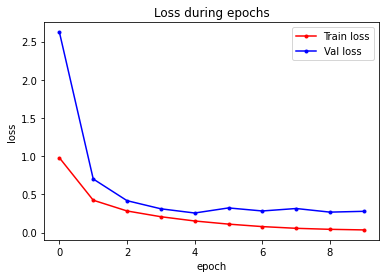

In [113]:
# loss 그래프
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

x = range(len(train_loss))
plt.plot(x, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x, val_loss, marker='.', color='blue', label='Val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss during epochs')
plt.show()

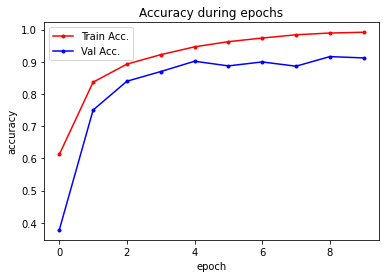

In [114]:
# acc 그래프
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(x, train_acc, marker='.', c='red', label='Train Acc.')
plt.plot(x, val_acc, marker='.', c='blue', label='Val Acc.')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy during epochs')
plt.show()

In [115]:
# Test set으로 모델 평가
score = model.evaluate(X_test, y_test, verbose=0)
print('Training loss:', score[0])
print('Training accuracy: ', score[1])

Training loss: 0.2778761684894562
Training accuracy:  0.9069409966468811


In [116]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
test_true = np.argmax(y_test, axis=1)
print(test_true)
test_pred = np.argmax(model.predict(X_test), axis=1)
print(test_pred)

cm = confusion_matrix(test_true, test_pred)
print(cm)

[0 3 3 ... 1 2 3]
[0 3 3 ... 1 2 3]
[[ 931   23   48    1    5]
 [   9  845  199    1    1]
 [  20  106  904    1    3]
 [   8   21   18 1098    6]
 [   5    0    4    5  939]]


In [117]:
# Classification Report
from sklearn.metrics import classification_report
report = classification_report(test_true, test_pred, target_names=os.listdir('/content/drive/My Drive/data_label'))
print(report)

              precision    recall  f1-score   support

       nevus       0.96      0.92      0.94      1008
          df       0.85      0.80      0.82      1055
      eschar       0.77      0.87      0.82      1034
          vl       0.99      0.95      0.97      1151
         mel       0.98      0.99      0.98       953

    accuracy                           0.91      5201
   macro avg       0.91      0.91      0.91      5201
weighted avg       0.91      0.91      0.91      5201



˙ 프로젝트 진행 기간에 구현했던 것과 비교해 한 epoch 당 학습 시간 약 8초 감소 </br>
˙ 오버피팅 눈에 띄게 감소, 안정된 그래프 </br>
˙ 정확도 4% 개선, 구버전과 비교시 vl과 mel의 구별 성능이 매우 향상 </br>
˙ eschar 부분에서도 전반적으로 성능 향상을 보였으나 정밀도에서 다소 성능이 떨어지는 모습을 보임, 개선 필요

